### ReservoirPy
#### Uses Numpy and Scipy for all Computations
https://github.com/reservoirpy/reservoirpy?tab=readme-ov-file

In [140]:
import reservoirpy as rpy
import numpy as np
import scipy
import matplotlib.pyplot as plt

#### Sample Timeseries Data

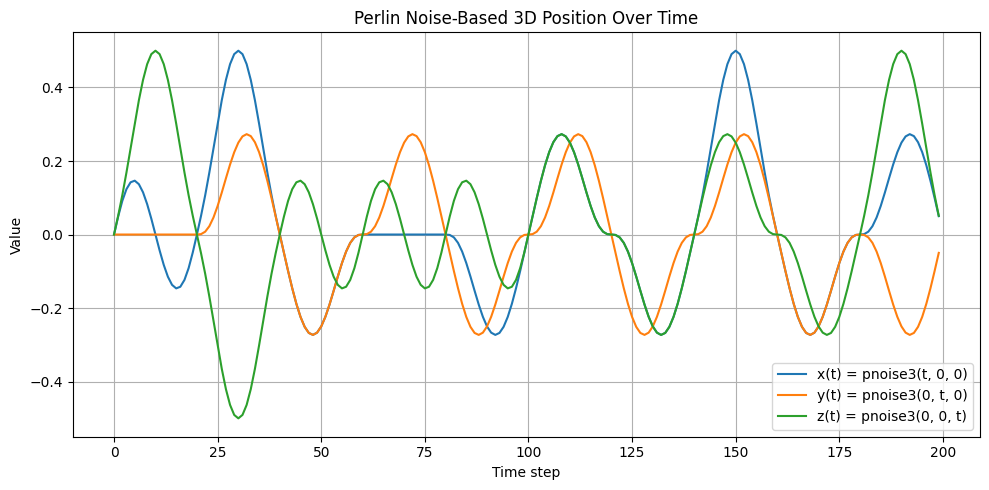

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise3

# Parameters
timesteps = 200
scale = 0.05

# Generate Perlin noise for x(t), y(t), z(t)
x = np.array([pnoise3(t * scale, 0, 0) for t in range(timesteps)])
y = np.array([pnoise3(0, t * scale, 0) for t in range(timesteps)])
z = np.array([pnoise3(0, 0, t * scale) for t in range(timesteps)])
X = np.stack([x, y, z], axis=1) 

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x, label='x(t) = pnoise3(t, 0, 0)')
plt.plot(y, label='y(t) = pnoise3(0, t, 0)')
plt.plot(z, label='z(t) = pnoise3(0, 0, t)')
plt.title("Perlin Noise-Based 3D Position Over Time")
plt.xlabel("Time step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Reservoir Generation

Reservoir class - reservoir;
Ridge node  - readout layer on reservoir's activations

In [142]:
rpy.verbosity(0) 
rpy.set_seed(42) # reproducibility

In [143]:
res = rpy.nodes.Reservoir(20,lr=0.5,sr=0.9)
print(res)


'Reservoir-18': Reservoir(lr=0.5, sr=0.9, input_scaling=1.0, bias_scaling=1.0, fb_scaling=1.0, rc_connectivity=0.1, input_connectivity=0.1, fb_connectivity=0.1, noise_in=0.0, noise_rc=0.0, noise_out=0.0, noise_type=normal, activation=<function tanh at 0x1083962a0>, fb_activation=<function identity at 0x1083963e0>, units=20, noise_generator=functools.partial(<function noise at 0x11401b380>, rng=Generator(PCG64) at 0x115ED73E0), in=None, out=20)


#### Single Node

In [144]:
res = res.reset() # optional line to reset reservoir

In [145]:
states = res.run(X) # takes arrays of (timesteps, features) and returns (timesteps, states)
print(np.shape(states))
# same as : 

# states = np.empty((len(X), res.output_dim))
# for i in range(len(X)):
#     states[i] = res(X[i].reshape(1, -1))



(200, 20)


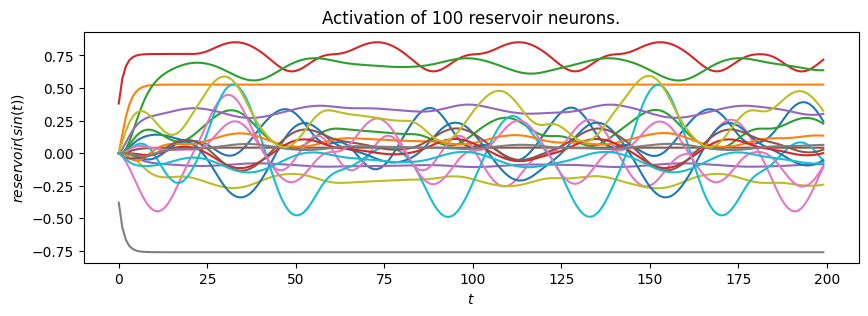

In [146]:
plt.figure(figsize=(10, 3))
plt.title("Activation of 100 Reservoir Neurons")
plt.ylabel("$reservoir(sin(t))$")
plt.xlabel("$t$")
plt.plot(states[:, :20])
plt.show()

#### Training Task

Given our data at step $t$, predict its state at $t=t+\Delta t$.

Setting arbitrary $\Delta t = 5$:

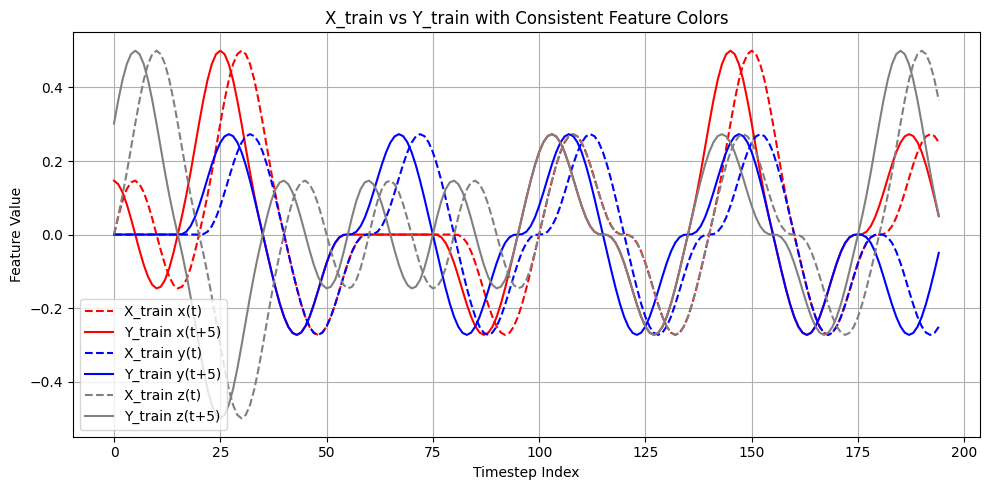

In [147]:
X_train = X[:195]
Y_train = X[5:200]

# Define colors for each feature
colors = ['red', 'blue', 'gray']
labels = ['x', 'y', 'z']

plt.figure(figsize=(10, 5))

for i in range(3):
    plt.plot(X_train[:, i], linestyle='--', color=colors[i], label=f'X_train {labels[i]}(t)')
    plt.plot(Y_train[:, i], linestyle='-',  color=colors[i], label=f'Y_train {labels[i]}(t+5)')

plt.title("X_train vs Y_train with Consistent Feature Colors")
plt.xlabel("Timestep Index")
plt.ylabel("Feature Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [148]:
from reservoirpy.nodes import Reservoir, Ridge

reservoir = Reservoir(100, lr=0.5, sr=0.9)
ridge = Ridge(ridge=1e-7)

esn_model = reservoir >> ridge

esn_model = esn_model.fit(X_train, Y_train, warmup=10)

print('Reservoir Initialized: ',reservoir.is_initialized, '\nReadout Initialized:',readout.is_initialized, '\nReadout Fitted:', readout.fitted)

Reservoir Initialized:  True 
Readout Initialized: False 
Readout Fitted: False


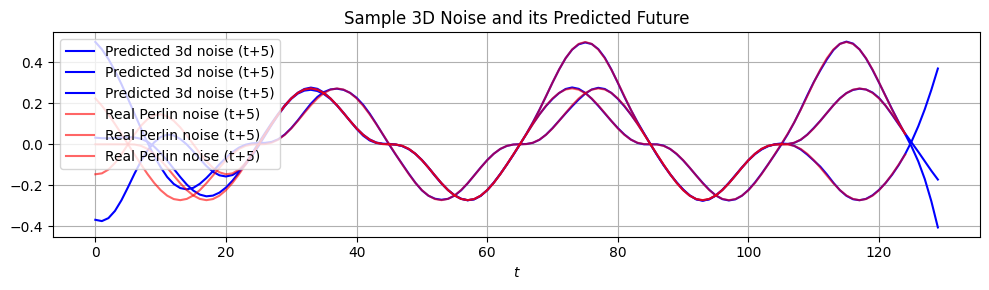

In [149]:
warmup = 20

Y_pred = esn_model.run(X[50:])
test_states = res.run(X[50:195])
Y_true = X[55:200]

warmup = 20
Y_pred = Y_pred[warmup:]
Y_true = Y_true[warmup:]

plt.figure(figsize=(10, 3))
plt.title("Sample 3D Noise and its Predicted Future")
plt.xlabel("$t$")
plt.plot(Y_pred, label="Predicted 3d noise (t+5)", color="blue")
plt.plot(Y_true, label="Real Perlin noise (t+5)", color="red", alpha=0.6)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
